# Neural Network for racetime prediction

### Define a logger for logging experiments configurations and results

In [1]:
import json
import os
from datetime import datetime
from pytorch_lightning.loggers import Logger
from pytorch_lightning.utilities.rank_zero import rank_zero_only

class F1NeuralNetworkExperimentsLogger(Logger):
    def __init__(self):
        super().__init__()
        self.metrics = []
        self.logs = {}
        self._version = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

    @property
    def name(self):
        return "F1NeuralNetworkExperimentsLogger"

    @property
    def version(self):
        return self._version
    
    @rank_zero_only
    def log_model_architecture(self, model):
        def layer_to_dict(layer):
            """Convert a PyTorch layer to a structured dictionary."""
            return {
                'type': layer.__class__.__name__,
                'parameters': {
                    name: p.shape if hasattr(p, 'shape') else str(p)
                    for name, p in layer.named_parameters(recurse=False)
                },
                'submodules': [layer_to_dict(sub) for sub in layer.children()]
            }

        architecture_dict = layer_to_dict(model)
        self.logs['model_architecture'] = architecture_dict


    @rank_zero_only
    def log_hyperparams(self, params):
        self.logs['hyperparameters'] = {k: str(v) for k, v in params.items()}

    @rank_zero_only
    def log_metrics(self, metrics, step):
        self.metrics.append((step, metrics))
        if 'metrics' not in self.logs:
            self.logs['metrics'] = []
        self.logs['metrics'].append({'step': step, 'metrics': {k: float(v) for k, v in metrics.items()}})

    @rank_zero_only
    def log_overall_test_loss(self, test_loss):
        self.logs['overall_test_loss'] = test_loss

    @rank_zero_only
    def log_used_features(self, features):
        self.logs['used_features'] = features

    @rank_zero_only
    def log_optimization_strategy(self, optimizer, scheduler):
        optimizer_str = str(optimizer)
        scheduler_str = str(scheduler)
        self.logs['optimizer'] = optimizer_str
        self.logs['scheduler'] = scheduler_str

    @rank_zero_only
    def save(self):
        directory = os.path.join(self.name, self.version)
        if not os.path.exists(directory):
            os.makedirs(directory)
        with open(os.path.join(directory, "logs.json"), "w") as f:
            json.dump(self.logs, f, indent=4)

    @rank_zero_only
    def finalize(self, status):
        self.save()

logger = F1NeuralNetworkExperimentsLogger()

### Preprocess and load the features and labels for regression

In [2]:
from data_preparation import load_and_preprocess_data, prepare_regression_data, split_data_by_race
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler

class F1Dataset(Dataset):
    def __init__(self, X, y, scaler=None):
        super().__init__()
        self.X = X.reset_index(drop=True)
        print(self.X.columns)
        self.y = y.reset_index(drop=True)
        self.scaler = scaler
        if self.scaler:
            self.scaler.fit(self.X)
            self.X = pd.DataFrame(self.scaler.fit_transform(self.X), columns=self.X.columns)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        X = torch.tensor(self.X.iloc[idx].values, dtype=torch.float32)  # Access by iloc
        y = torch.tensor(self.y.iloc[idx], dtype=torch.float32)  # Access by iloc
        return X, y

train_df, test_df = split_data_by_race(load_and_preprocess_data())
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=42)

X_train, y_train = prepare_regression_data(train_df)
X_val, y_val = prepare_regression_data(val_df)
X_test, y_test = prepare_regression_data(test_df)

N_FEATURES = X_train.shape[1]
print(f"Number of features: {N_FEATURES}")


scaler = StandardScaler()

train_dataset = F1Dataset(X_train, y_train, scaler=scaler)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = F1Dataset(X_val, y_val, scaler=scaler)
val_dataloader = DataLoader(val_dataset, batch_size=32)
test_dataset = F1Dataset(X_test, y_test, scaler=scaler)
test_dataloader = DataLoader(test_dataset, batch_size=32)

train_dataset.__getitem__(0)

/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/data_preparation.py:25: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  practice_sessions = pd.read_csv('../data/raw_data/ff1_laps.csv', na_values=na_values)
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/data_preparation.py:26: DtypeWarning: Columns (28) have mixed types. Specify dtype option on import or set low_memory=False.
  tire_data = pd.read_csv('../data/raw_data/ff1_laps.csv', na_values=na_values)


(586171, 15)
(586171, 32)
(586171, 40)
(586171, 45)
(586171, 46)
(586171, 47)
(586171, 47)


/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/data_preparation.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  laps['pitstop_milliseconds'].fillna(0, inplace=True)  # Assuming 0 if no pit stop
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/data_preparation.py:106: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace meth

(586171, 56)


/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/data_preparation.py:196: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  laps['Compound'].fillna('UNKNOWN', inplace=True)
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/data_preparation.py:249: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the i

Matching for 1
Matching for 2
Matching for 3
Matching for 4
Matching for 5
Matching for 6
Matching for 7
Matching for 8
Matching for 9
Matching for 10
Matching for 11
Matching for 12
Matching for 13
Matching for 14
Matching for 15
Matching for 16
Matching for 17
Matching for 18
Matching for 19
Matching for 20
Matching for 21
Matching for 22
Matching for 23
Matching for 24
Matching for 25
Matching for 26
Matching for 27
Matching for 28
Matching for 29
Matching for 30
Matching for 31
Matching for 32
Matching for 33
Matching for 34
Matching for 35
Matching for 36
Matching for 37
Matching for 38
Matching for 39
Matching for 40
Matching for 41
Matching for 42
Matching for 43
Matching for 44
Matching for 45
Matching for 46
Matching for 47
Matching for 48
Matching for 49
Matching for 50
Matching for 51
Matching for 52
Matching for 53
Matching for 54
Matching for 55
Matching for 56
Matching for 57
Matching for 58
Matching for 59
Matching for 60
Matching for 61
Matching for 62
Matching for 63
M

/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/data_preparation.py:570: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  laps['TrackStatus'].fillna(1, inplace=True)  # 1 = regular racing status


Shape before filtering and outlier removal: (586171, 95)
Normal racing laps: (528281, 95)
Special laps (pit stops, safety car, etc.): (57890, 95)
Final shape after outlier removal: (497845, 95)
Number of features: 19
Index(['driver_overall_skill', 'driver_circuit_skill', 'driver_consistency',
       'driver_reliability', 'driver_aggression', 'driver_risk_taking',
       'fp1_median_time', 'fp2_median_time', 'fp3_median_time', 'quali_time',
       'tire_age', 'fuel_load', 'track_position', 'track_temp', 'air_temp',
       'humidity', 'tire_compound', 'TrackStatus', 'is_pit_lap'],
      dtype='object')
Index(['driver_overall_skill', 'driver_circuit_skill', 'driver_consistency',
       'driver_reliability', 'driver_aggression', 'driver_risk_taking',
       'fp1_median_time', 'fp2_median_time', 'fp3_median_time', 'quali_time',
       'tire_age', 'fuel_load', 'track_position', 'track_temp', 'air_temp',
       'humidity', 'tire_compound', 'TrackStatus', 'is_pit_lap'],
      dtype='object')
I

(tensor([ 2.6138,  2.6138, -0.7618,  1.2688, -0.7402, -0.7402,  1.3663,  1.6937,
          0.3808,  0.9045, -0.8811, -0.0046, -1.6040,  0.0000,  0.0000,  0.0000,
         -0.8227,  0.0000,  0.0000]),
 tensor(108247.))

### Model

In [3]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt

class LaptimePredicionModel(pl.LightningModule):
    def __init__(self, lr=0.005, loss_fn=nn.MSELoss, optimizer=torch.optim.AdamW, layer_config=(2, 64)):
        super().__init__()
        self.save_hyperparameters(logger=True)
        self.predictions = []
        self.actuals = []
        self.train_losses = []
        self.val_losses = []
        self.test_losses = []
        self.lr = lr
        self.INPUT_DIM = N_FEATURES
        self.OUTPUT_DIM = 1

        # Get the number of layers and neurons per layer from layer_config
        num_layers, neurons_per_layer = layer_config
        
        # Build the model dynamically
        layers = []
        
        in_features = self.INPUT_DIM
        layers.append(nn.Linear(in_features, neurons_per_layer))
        for i in range(num_layers):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(nn.ReLU())
            in_features = neurons_per_layer
        
        # Final output layer
        layers.append(nn.Linear(neurons_per_layer, self.OUTPUT_DIM))

        self.model = nn.Sequential(*layers)
        self.loss_fn = loss_fn() if callable(loss_fn) else loss_fn
        self.optimizer = optimizer(self.model.parameters(), lr=self.lr)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        loss = self.loss_fn(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.train_losses.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        test_loss_fn = nn.MSELoss()
        loss = torch.sqrt(test_loss_fn(y_hat, y))
        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.val_losses.append(loss.item())
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x).squeeze(-1)
        test_loss_fn = nn.MSELoss()
        loss = torch.sqrt(test_loss_fn(y_hat, y))
        self.predictions.extend(y_hat.cpu().numpy())
        self.actuals.extend(y.cpu().numpy())
        self.test_losses.append(loss.item())
        return loss

    def on_test_epoch_end(self):
        avg_test_loss = sum(self.test_losses) / len(self.test_losses)
        print(f"Average Test Loss: {avg_test_loss}")
        
        # Set the background color to black
        plt.figure(figsize=(8, 6))
        ax = plt.gca()  # Get the current axis
        ax.set_facecolor('black')  # Set the plot area background color to black

        # Scatter plot with blue points and blue edges
        plt.scatter(self.actuals, self.predictions, alpha=0.6, color='b', edgecolor='b')  

        # Customize axis labels, title, and grid
        plt.xlabel('Actual Values', color='w')  # White axis label
        plt.ylabel('Predicted Values', color='w')  # White axis label
        plt.title('Correlation between Actual and Predicted Values', color='w')  # White title
        plt.grid(True, color='w')  # White grid lines
        
        # Customize the spines (axes borders) to have black background behind labels
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('w')
        ax.spines['bottom'].set_color('w')

        # Set the ticks and their labels to white
        ax.tick_params(axis='both', colors='w')

        plt.show()
        
        self.plot_loss_curve()

    def on_train_epoch_end(self):
        self.train_losses.clear()

    def configure_optimizers(self):
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            self.optimizer,
            max_lr=self.hparams.lr,
            steps_per_epoch=100,
            epochs=10,
            anneal_strategy='cos',
        )
        return {
            'optimizer': self.optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'val_loss'
        }

    def plot_loss_curve(self):
        # Set the background color to black
        plt.figure(figsize=(10, 5))
        ax = plt.gca()  # Get the current axis
        ax.set_facecolor('black')  # Set the plot area background color to black

        if self.val_losses:
            plt.plot(self.val_losses, label='Validation Loss', color='b')  # Blue line for loss curve

        # Customize axis labels, title, and grid
        plt.xlabel('Epoch', color='w')  # White axis label
        plt.ylabel('Loss', color='w')  # White axis label
        plt.title('Loss Curve', color='w')  # White title
        plt.legend(frameon=False, loc='best', facecolor='black', edgecolor='w', labelcolor='w')  # White text for legend
        plt.grid(True, color='w')  # White grid lines

        # Customize the spines (axes borders) to have black background behind labels
        ax.spines['top'].set_color('w')
        ax.spines['right'].set_color('w')
        ax.spines['left'].set_color('w')
        ax.spines['bottom'].set_color('w')

        # Set the ticks and their labels to white
        ax.tick_params(axis='both', colors='w')

        plt.show()

### Configure callback functions

In [4]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=3,          
    verbose=True,
    mode="min"           
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",     
    filename="best_model-{epoch:02d}-{val_loss:.2f}",
    save_top_k=1,             
    mode="min",                  
    verbose=True
)

### Determine optimal amount of model layers and neurons per layer

In [5]:
"""import pytorch_lightning as pl
import optuna

def objective(trial):
    num_layers = trial.suggest_int('num_layers', 2, 6)
    neurons_per_layer = trial.suggest_int('neurons_per_layer', 32, 128)

    model = LaptimePredicionModel(layer_config=(num_layers, neurons_per_layer))

    trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[early_stopping, checkpoint_callback])

    trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    avg_val_loss = sum(model.val_losses) / len(model.val_losses)
    print(f"Test Loss for {num_layers} layers, {neurons_per_layer} neurons per layer: {avg_val_loss:.4f}")

    return avg_val_loss


def optimize_hyperparameters():
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10)

    print("Best Hyperparameters: ", study.best_params)
    print("Best Value (Test Loss): ", study.best_value)
    
optimize_hyperparameters()"""

'import pytorch_lightning as pl\nimport optuna\n\ndef objective(trial):\n    num_layers = trial.suggest_int(\'num_layers\', 2, 6)\n    neurons_per_layer = trial.suggest_int(\'neurons_per_layer\', 32, 128)\n\n    model = LaptimePredicionModel(layer_config=(num_layers, neurons_per_layer))\n\n    trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[early_stopping, checkpoint_callback])\n\n    trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)\n\n    avg_val_loss = sum(model.val_losses) / len(model.val_losses)\n    print(f"Test Loss for {num_layers} layers, {neurons_per_layer} neurons per layer: {avg_val_loss:.4f}")\n\n    return avg_val_loss\n\n\ndef optimize_hyperparameters():\n    study = optuna.create_study(direction=\'minimize\')\n    study.optimize(objective, n_trials=10)\n\n    print("Best Hyperparameters: ", study.best_params)\n    print("Best Value (Test Loss): ", study.best_value)\n    \noptimize_hyperparameters()'

### Determine the optimal learning rate, optimizer and loss function

In [6]:
"""# Define the objective function for Optuna
def objective(trial):
    # Sample hyperparameters from the search space
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)  # Learning rate (log scale)
    
    # Choose optimizer: Adam, AdamW, or SGD
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = torch.optim.Adam
    elif optimizer_name == 'AdamW':
        optimizer = torch.optim.AdamW
    else:
        optimizer = torch.optim.SGD

    # Choose loss function: L1Loss or MSELoss
    loss_fn_name = trial.suggest_categorical('loss_fn', ['L1Loss', 'MSELoss'])
    if loss_fn_name == 'L1Loss':
        loss_fn = nn.L1Loss
    else:
        loss_fn = nn.MSELoss

    # Initialize the model with the fixed architecture and selected loss function
    model = LaptimePredicionModel(lr=lr, loss_fn=loss_fn, optimizer=optimizer)
    
    trainer = pl.Trainer(max_epochs=10, logger=logger, callbacks=[early_stopping, checkpoint_callback])

    trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

    # Calculate average test loss
    avg_val_loss = sum(model.val_losses) / len(model.val_losses)
    print(f"Test Loss for Optimizer: {optimizer_name}, Loss function: {loss_fn_name}, "
          f"Learning rate: {lr:.6f}: {avg_val_loss:.4f}")

    return avg_val_loss  # We aim to minimize the test loss

# Function to run the optimization process
def optimize_hyperparameters():
    # Create an Optuna study to minimize the test loss
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=10)  # Run 10 trials

    # Print the best hyperparameters found by Optuna
    print("Best Hyperparameters: ", study.best_params)
    print("Best Test Loss: ", study.best_value)

# Start the optimization process
optimize_hyperparameters()"""

'# Define the objective function for Optuna\ndef objective(trial):\n    # Sample hyperparameters from the search space\n    lr = trial.suggest_loguniform(\'lr\', 1e-5, 1e-2)  # Learning rate (log scale)\n    \n    # Choose optimizer: Adam, AdamW, or SGD\n    optimizer_name = trial.suggest_categorical(\'optimizer\', [\'Adam\', \'AdamW\', \'SGD\'])\n    if optimizer_name == \'Adam\':\n        optimizer = torch.optim.Adam\n    elif optimizer_name == \'AdamW\':\n        optimizer = torch.optim.AdamW\n    else:\n        optimizer = torch.optim.SGD\n\n    # Choose loss function: L1Loss or MSELoss\n    loss_fn_name = trial.suggest_categorical(\'loss_fn\', [\'L1Loss\', \'MSELoss\'])\n    if loss_fn_name == \'L1Loss\':\n        loss_fn = nn.L1Loss\n    else:\n        loss_fn = nn.MSELoss\n\n    # Initialize the model with the fixed architecture and selected loss function\n    model = LaptimePredicionModel(lr=lr, loss_fn=loss_fn, optimizer=optimizer)\n    \n    trainer = pl.Trainer(max_epochs=10

### Final Training with best configuration

In [7]:
model = LaptimePredicionModel()
trainer = pl.Trainer(
    callbacks=[early_stopping, checkpoint_callback],
    log_every_n_steps=10,
    max_epochs=10,
)

trainer.fit(model=model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | model   | Sequential | 9.7 K  | train
1 | loss_fn | MSELoss    | 0      | train
-----------------------------------------------
9.7 K     Trainable params
0         Non-trainable params
9.7 K     Total params
0.039     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 57411.914
Epoch 0, global step 1665: 'val_loss' reached 57411.91406 (best 57411.91406), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_17/checkpoints/best_model-epoch=00-val_loss=57411.91.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 12613.512 >= min_delta = 0.0. New best score: 44798.402
Epoch 1, global step 3330: 'val_loss' reached 44798.40234 (best 44798.40234), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_17/checkpoints/best_model-epoch=01-val_loss=44798.40.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 17362.744 >= min_delta = 0.0. New best score: 27435.658
Epoch 2, global step 4995: 'val_loss' reached 27435.65820 (best 27435.65820), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_17/checkpoints/best_model-epoch=02-val_loss=27435.66.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 17211.570 >= min_delta = 0.0. New best score: 10224.088
Epoch 3, global step 6660: 'val_loss' reached 10224.08789 (best 10224.08789), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_17/checkpoints/best_model-epoch=03-val_loss=10224.09.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 3520.662 >= min_delta = 0.0. New best score: 6703.426
Epoch 4, global step 8325: 'val_loss' reached 6703.42578 (best 6703.42578), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_17/checkpoints/best_model-epoch=04-val_loss=6703.43.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 1565.580 >= min_delta = 0.0. New best score: 5137.846
Epoch 5, global step 9990: 'val_loss' reached 5137.84619 (best 5137.84619), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_17/checkpoints/best_model-epoch=05-val_loss=5137.85.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 716.461 >= min_delta = 0.0. New best score: 4421.385
Epoch 6, global step 11655: 'val_loss' reached 4421.38525 (best 4421.38525), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_17/checkpoints/best_model-epoch=06-val_loss=4421.39.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 242.930 >= min_delta = 0.0. New best score: 4178.455
Epoch 7, global step 13320: 'val_loss' reached 4178.45508 (best 4178.45508), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_17/checkpoints/best_model-epoch=07-val_loss=4178.46.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 86.819 >= min_delta = 0.0. New best score: 4091.636
Epoch 8, global step 14985: 'val_loss' reached 4091.63574 (best 4091.63574), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_17/checkpoints/best_model-epoch=08-val_loss=4091.64.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved by 25.160 >= min_delta = 0.0. New best score: 4066.475
Epoch 9, global step 16650: 'val_loss' reached 4066.47534 (best 4066.47534), saving model to '/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/lap_simulation/lightning_logs/version_17/checkpoints/best_model-epoch=09-val_loss=4066.48.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


/Users/i551965/Documents/dev/Uni/DataMining/ie500-data-mining-group7/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Average Test Loss: 4067.5532276387116


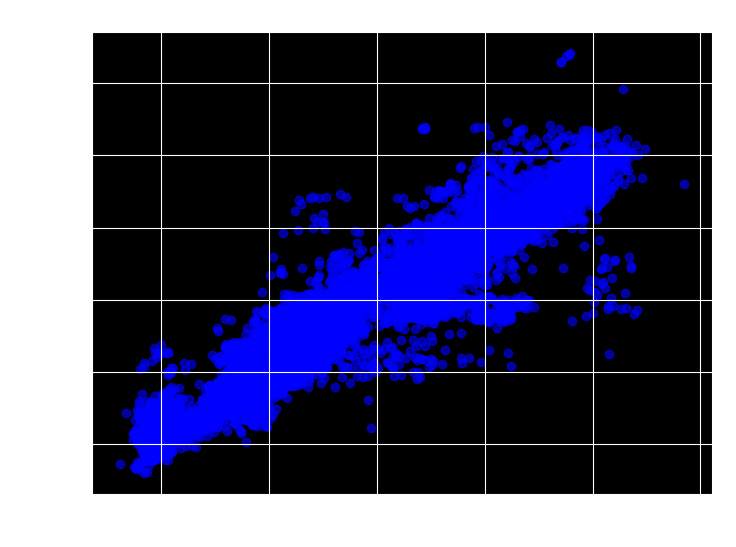

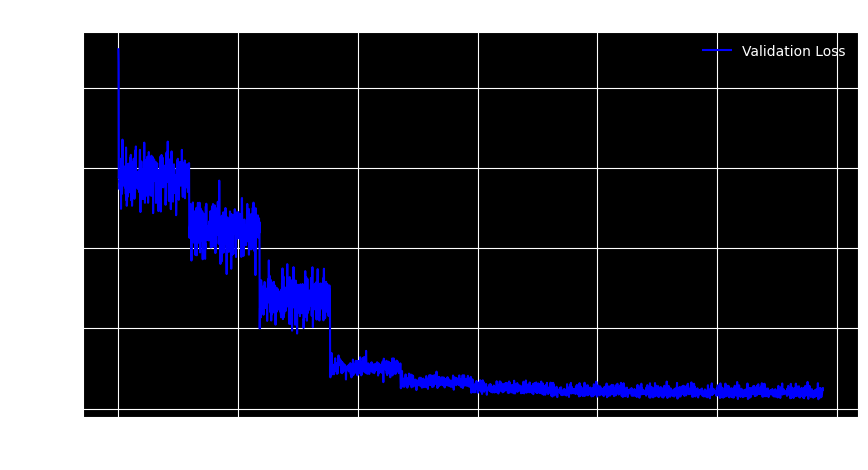

[{}]

In [8]:
trainer.test(model, val_dataloader)

### Final Evaluation on test data

Testing: |          | 0/? [00:00<?, ?it/s]

Average Test Loss: 3963.0864317487963


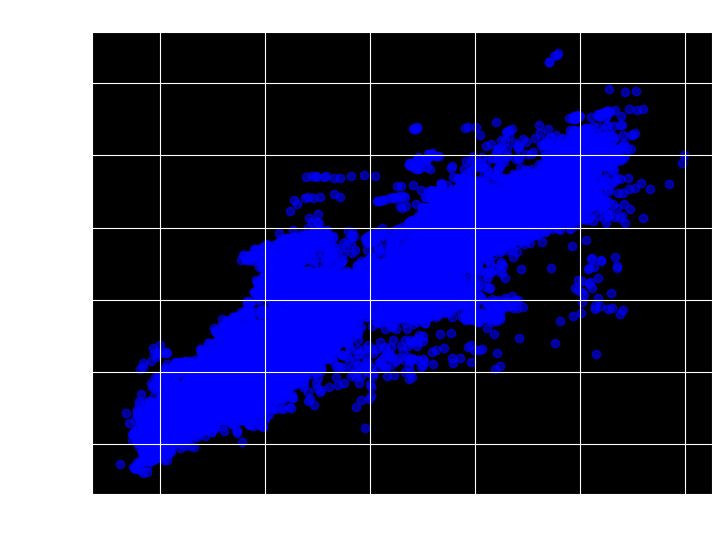

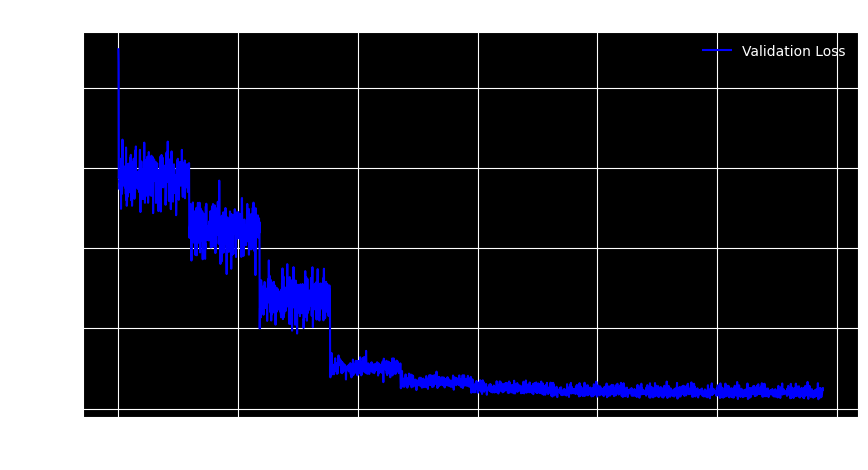

[{}]

In [9]:
trainer.test(model=model, dataloaders=test_dataloader)